In [1]:
%matplotlib inline
import scipy.special, cmath
import random, math, pylab, os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pylab
import mpl_toolkits.mplot3d
from matplotlib.patches import FancyArrowPatch, Circle, Rectangle

In [2]:
#padding on the y axis between label and axis
plt.rcParams['ytick.major.pad']='10'

dpi_out = 400
fig_width = 3.39
golden_mean = (np.sqrt(5)-1.0)/2.0    # Aesthetic ratio
fig_height = fig_width*golden_mean # height in inches
MAX_HEIGHT_INCHES = 8.0
if fig_height > MAX_HEIGHT_INCHES:
    print("WARNING: fig_height too large:" + fig_height + 
          "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
    fig_height = MAX_HEIGHT_INCHES
#fig, ax = plt.subplots(figsize = (fig_width, fig_height), dpi=400, frameon=True)
small_tick_size = 8
small_label_size = 8

## Naive calculation of the the energy in the $2 \times 2$ Ising model 

In [3]:
def energy(S, N, nbr):
    E = 0.0
    for k in range(N):
        E -=  S[k] * sum(S[nn] for nn in nbr[k])
    return 0.5 * E

L = 2
nbr = [[1, 2], [3, 0], [3, 0], [2, 1]]
S = [1, 1, -1, 1]
print S, energy(S, L * L, nbr)


[1, 1, -1, 1] 0.0


## Gray code for Ising model

In [4]:
def gray_flip(t):
    N = len(t) - 1
    k = t[0]
    if k > N: 
        return t, k
    t[k - 1] = t[k]
    t[k] = k + 1
    if k != 1: 
        t[0] = 1
    return k, t

### Enumeration of configurations

In [5]:
def plot_spin(c, filename, L):
    s = 1.0 / L
    for i in range(L):
        for j in range(L):
            x, y, dy = (i + 0.5) * s, (j + 0.5) * s, 0.85 * s * c[i][j]
            arrow = FancyArrowPatch((x, y - 0.5 * dy), (x, y + 0.5 * dy),
                    color='.2', lw=0, alpha=.8, arrowstyle="Simple" +
                    ", head_length=" + str(1.3 * 150 * s) +
                    ", head_width=" + str(1.3 * 150 * s) +
                    ", tail_width=" + str(1.3 * 40 * s))
            pylab.gca().add_patch(arrow)
    pylab.axis('scaled')
    pylab.axis([0, 1, 0, 1])
    pylab.gca().set_xticks([])
    pylab.gca().set_yticks([])
    [pylab.axhline(y=(i * s), ls='--', c='.2') for i in range(L)]
    [pylab.axvline(x=(j * s), ls='--', c='.2') for j in range(L)]
    pylab.savefig(filename)
    pylab.show()
    pylab.clf()

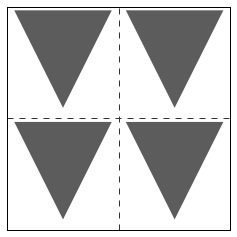

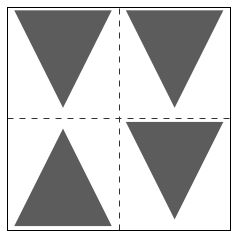

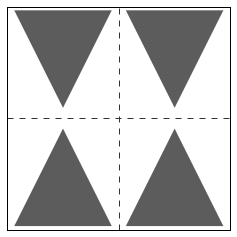

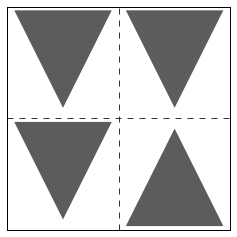

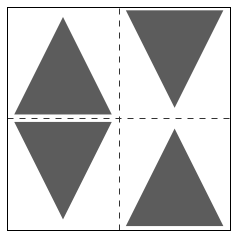

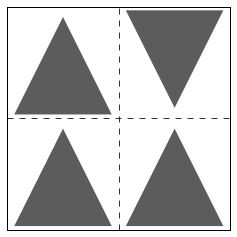

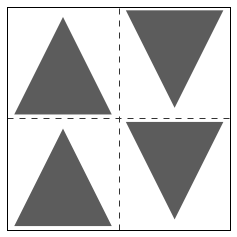

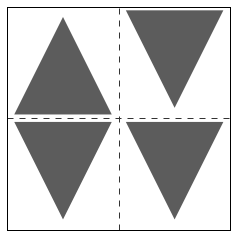

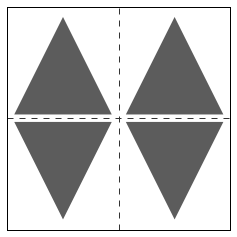

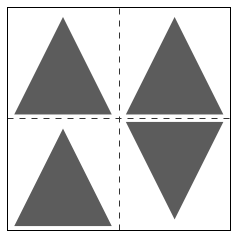

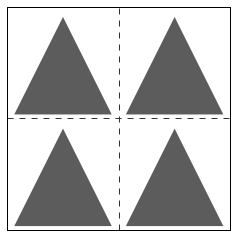

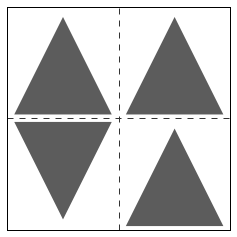

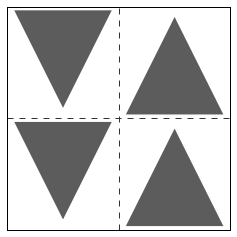

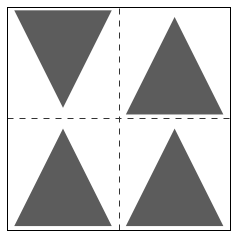

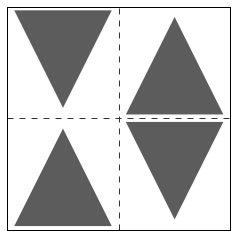

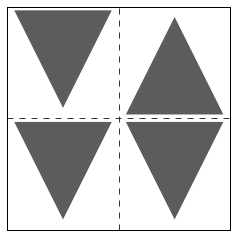

In [6]:
L = 2
N = L * L
site_dic = {(j // L, j - (j // L) * L) : j for j in range(N)}
S = [-1] * N
plot_spin([[S[site_dic[(a, b)]] for a in range(L)] for b in range(L)], 'spin_config_%04i.png' % 0, L)
tau = range(1, N + 2)
for i in range(1, 2 ** N):
    k, tau = gray_flip(tau)
    S[k - 1] *= -1
    plot_spin([[S[site_dic[(a, b)]] for a in range(L)] for b in range(L)], 'spin_config_%04i.png' % i, L)

### density of states for lattice with periodic boundary conditions

In [7]:
L = 4
N = L * L
nbr = {i : ((i // L) * L + (i + 1) % L, (i + L) % N,
            (i // L) * L + (i - 1) % L, (i - L) % N)
                                    for i in range(N)}
S = [-1] * N
E = -2 * N
dos = {}
dos[E] = 1
tau = range(1, N + 2)
for i in xrange(1, 2 ** N):
    k, tau = gray_flip(tau)
    h = sum(S[n] for n in nbr[k - 1])
    E += 2 * h * S[k - 1] 
    S[k - 1] *= -1
    if E in dos: 
        dos[E] += 1
    else:        
        dos[E] = 1
for E in sorted(dos.keys()):
    print E, dos[E]

-32 2
-24 32
-20 64
-16 424
-12 1728
-8 6688
-4 13568
0 20524
4 13568
8 6688
12 1728
16 424
20 64
24 32
32 2


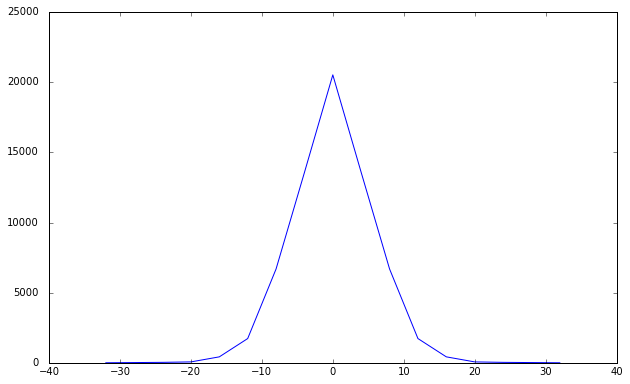

In [8]:
fig, ax = plt.subplots(figsize = (3*fig_width, 3*fig_height), dpi=400, frameon=True)
ax.plot([E for E in sorted(dos.keys())], [dos[E] for E in sorted(dos.keys())])

## Thermodynamics: specific heat capacity

In [9]:
L = 6
N = L * L
filename = 'data_dos_L%i.txt' % L

if os.path.isfile(filename):
    dos = {}
    f = open(filename, 'r')
    for line in f:
        E, N_E = line.split()
        dos[int(E)] = int(N_E)
    f.close()
else:
    print('input file missing')

In [10]:
list_T = [0.5 + 0.01 * i for i in range(500)]
list_cv = []
for T in list_T:
    Z = 0.0
    E_av = 0.0
    M_av = 0.0
    E2_av = 0.0
    for E in dos.keys():
        weight = math.exp(- E / T) * dos[E]
        Z += weight
        E_av += weight * E
        E2_av += weight * E ** 2
    E2_av /= Z
    E_av /= Z
    cv = (E2_av - E_av ** 2) / N / T ** 2
    list_cv.append(cv)

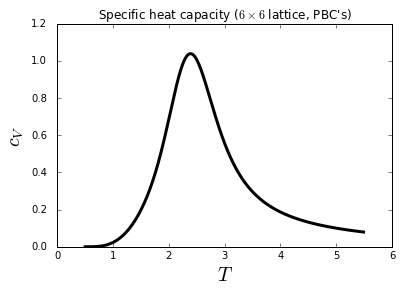

In [11]:
pylab.title('Specific heat capacity ($%i\\times%i$ lattice, PBC\'s)' % (L, L))
pylab.xlabel('$T$', fontsize=20)
pylab.ylabel('$c_V$', fontsize=20)
pylab.plot(list_T, list_cv, 'k-', lw=3)
pylab.show()

# Monte Carlo algorithms for the Ising model

## MCMC approach

In [12]:
L = 8
N = L * L
nbr = {i : ((i // L) * L + (i + 1) % L, (i + L) % N,
            (i // L) * L + (i - 1) % L, (i - L) % N) \
                                    for i in range(N)}
nsteps = 10000 * N
list_T = [1.0 + 0.2 * i for i in range(15)]
list_av_m = []
S = [random.choice([1, -1]) for k in range(N)]
M = sum(S)
for T in list_T:
    print 'T =', T
    beta = 1.0 / T
    M_tot = 0.0
    n_measures = 0
    for step in range(nsteps):
        k = random.randint(0, N - 1)
        delta_E = 2.0 * S[k] * sum(S[nn] for nn in nbr[k])
        if random.uniform(0.0, 1.0) < math.exp(-beta * delta_E):
            S[k] *= -1
            M += 2 * S[k]
        if step % N == 0 and step > nsteps / 2:
            M_tot += abs(M)
            n_measures += 1
    list_av_m.append(abs(M_tot) / float(n_measures * N))

T = 1.0
T = 1.2
T = 1.4
T = 1.6
T = 1.8
T = 2.0
T = 2.2
T = 2.4
T = 2.6
T = 2.8
T = 3.0
T = 3.2
T = 3.4
T = 3.6
T = 3.8


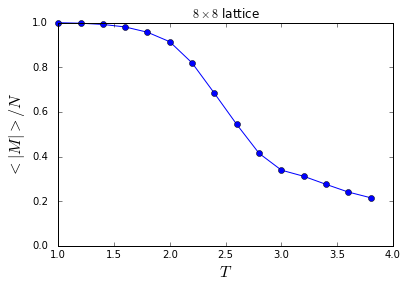

In [13]:
pylab.title('$%i\\times%i$ lattice' % (L, L))
pylab.xlabel('$T$', fontsize=16)
pylab.ylabel('$<|M|>/N$', fontsize=16)
pylab.plot(list_T, list_av_m, 'bo-', clip_on=False)
pylab.ylim(0.0, 1.0)
pylab.show()
pylab.savefig('plot_local_av_magnetization_L%i.png' % L)

## Heatbath algorithm

In [14]:
L = 6
N = L * L
nbr = {i : ((i // L) * L + (i + 1) % L, (i + L) % N,
            (i // L) * L + (i - 1) % L, (i - L) % N) for i in range(N)}
nsteps = 10000000
beta = 1.0
S = [random.choice([-1, 1]) for site in range(N)]
E = -0.5 * sum(S[k] * sum(S[nn] for nn in nbr[k]) for k in range(N))
E_tot, E2_tot = 0.0, 0.0
random.seed('123456')

for step in range(nsteps):
    k = random.randint(0, N - 1)
    Upsilon = random.uniform(0.0, 1.0)
    h = sum(S[nn] for nn in nbr[k])
    Sk_old = S[k]
    S[k] = -1
    if Upsilon < 1.0 / (1.0 + math.exp(-2.0 * beta * h)):
        S[k] = 1
    if S[k] != Sk_old:
        E -= 2.0 * h * S[k]
    E_tot += E
    E2_tot += E ** 2
E_av  = E_tot / float(nsteps)
E2_av = E2_tot / float(nsteps)
c_V = beta ** 2 * (E2_av - E_av ** 2) / float(N)

## Ising model: half order and perfect sampling

random initial config
step 0: no coupling yet, 21 different spins


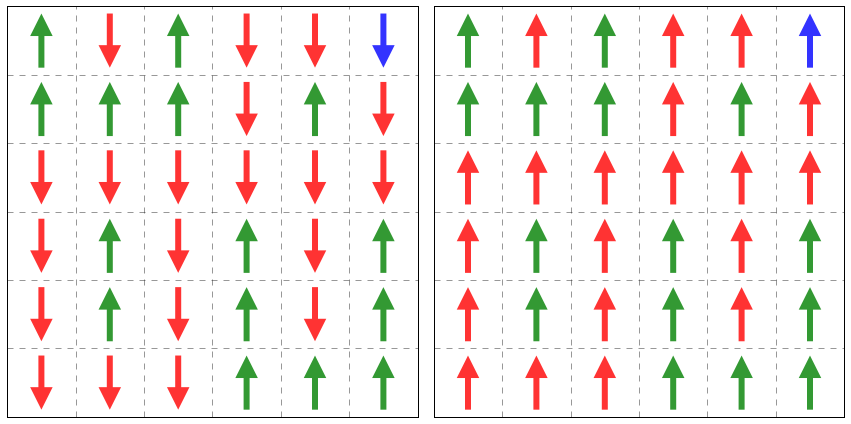

step 1: no coupling yet, 21 different spins
step 2: no coupling yet, 21 different spins
step 3: no coupling yet, 20 different spins
step 4: no coupling yet, 20 different spins
step 5: no coupling yet, 20 different spins
step 6: no coupling yet, 19 different spins
step 7: no coupling yet, 19 different spins
step 8: no coupling yet, 18 different spins
step 9: no coupling yet, 18 different spins
step 10: no coupling yet, 17 different spins


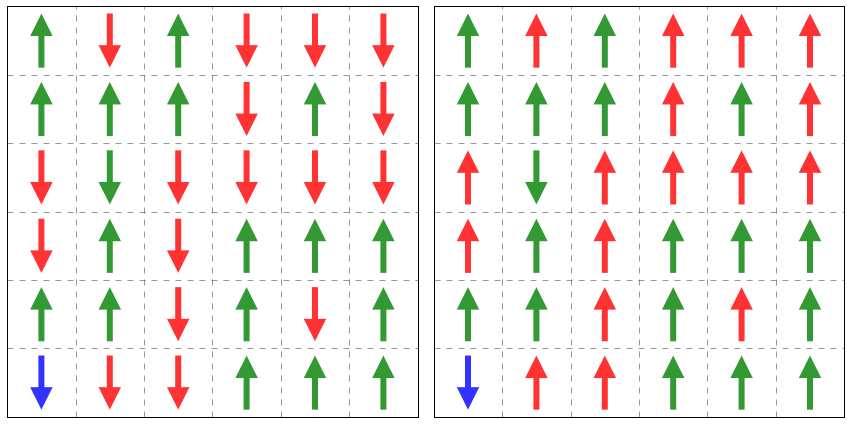

step 11: no coupling yet, 17 different spins
step 12: no coupling yet, 17 different spins
step 13: no coupling yet, 16 different spins
step 14: no coupling yet, 15 different spins
step 15: no coupling yet, 14 different spins
step 16: no coupling yet, 13 different spins
step 17: no coupling yet, 12 different spins
step 18: no coupling yet, 11 different spins
step 19: no coupling yet, 11 different spins
step 20: no coupling yet, 11 different spins


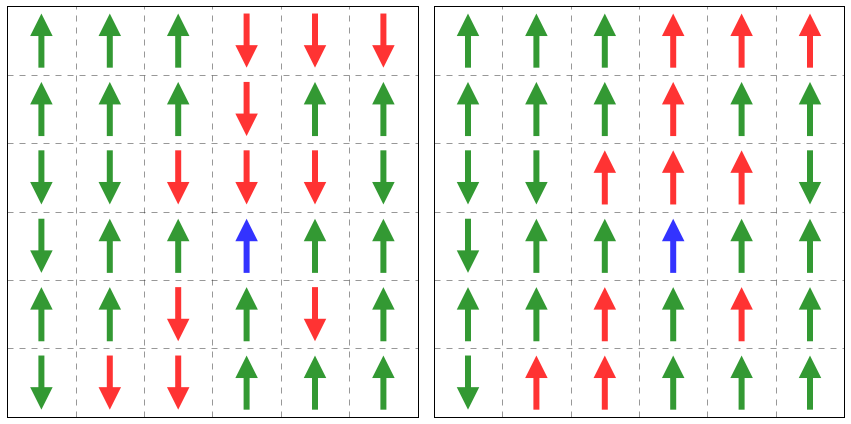

step 21: no coupling yet, 10 different spins
step 22: no coupling yet, 10 different spins
step 23: no coupling yet, 9 different spins
step 24: no coupling yet, 10 different spins
step 25: no coupling yet, 10 different spins
step 26: no coupling yet, 10 different spins
step 27: no coupling yet, 10 different spins
step 28: no coupling yet, 10 different spins
step 29: no coupling yet, 10 different spins
step 30: no coupling yet, 9 different spins


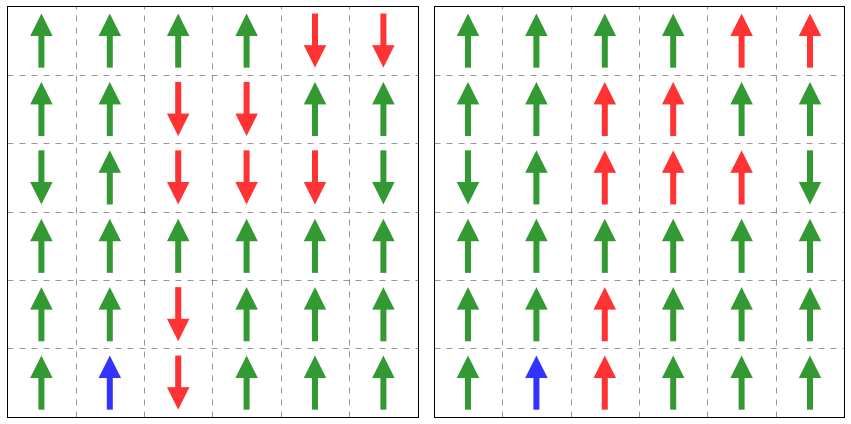

step 31: no coupling yet, 8 different spins
step 32: no coupling yet, 8 different spins
step 33: no coupling yet, 8 different spins
step 34: no coupling yet, 7 different spins
step 35: no coupling yet, 7 different spins
step 36: no coupling yet, 8 different spins
step 37: no coupling yet, 8 different spins
step 38: no coupling yet, 8 different spins
step 39: no coupling yet, 8 different spins
step 40: no coupling yet, 8 different spins


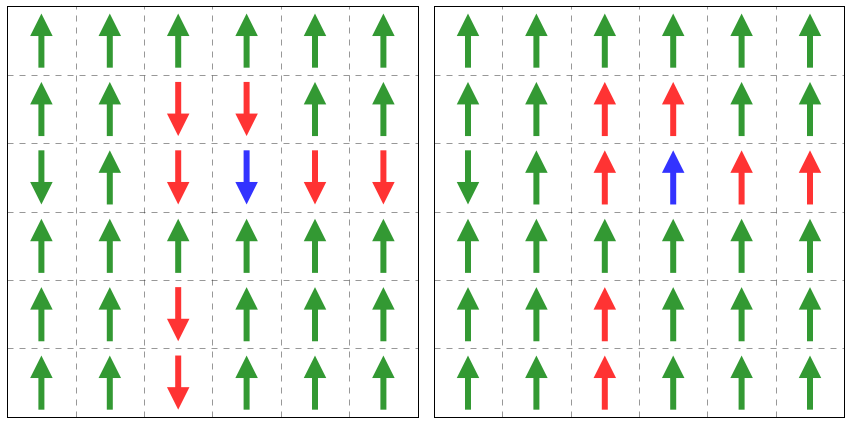

step 41: no coupling yet, 8 different spins
step 42: no coupling yet, 8 different spins
step 43: no coupling yet, 7 different spins
step 44: no coupling yet, 7 different spins
step 45: no coupling yet, 7 different spins
step 46: no coupling yet, 7 different spins
step 47: no coupling yet, 7 different spins
step 48: no coupling yet, 7 different spins
step 49: no coupling yet, 7 different spins
step 50: no coupling yet, 8 different spins


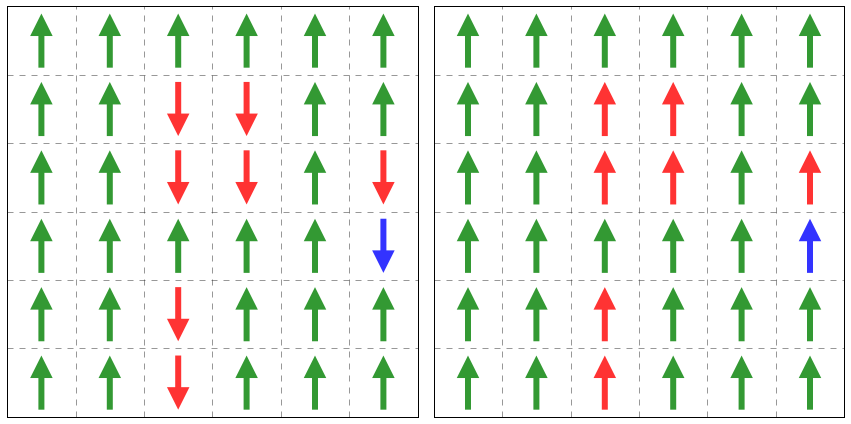

step 51: no coupling yet, 8 different spins
step 52: no coupling yet, 8 different spins
step 53: no coupling yet, 8 different spins
step 54: no coupling yet, 8 different spins
step 55: no coupling yet, 8 different spins
step 56: no coupling yet, 8 different spins
step 57: no coupling yet, 7 different spins
step 58: no coupling yet, 7 different spins
step 59: no coupling yet, 7 different spins
step 60: no coupling yet, 6 different spins


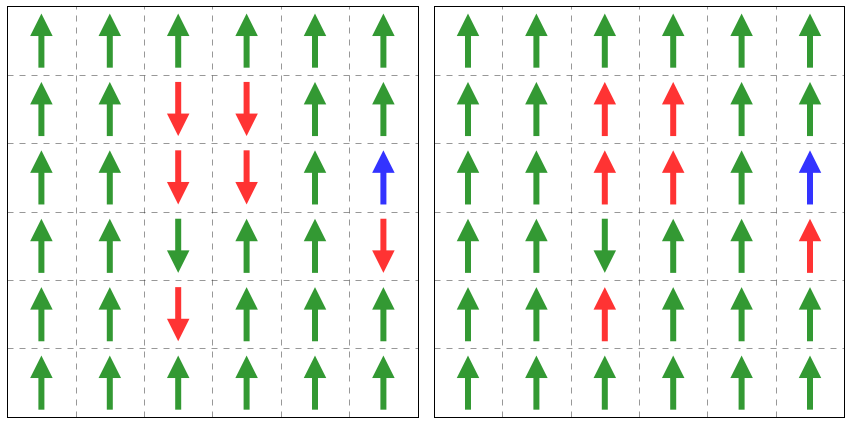

step 61: no coupling yet, 6 different spins
step 62: no coupling yet, 5 different spins
step 63: no coupling yet, 5 different spins
step 64: no coupling yet, 5 different spins
step 65: no coupling yet, 5 different spins
step 66: no coupling yet, 5 different spins
step 67: no coupling yet, 5 different spins
step 68: no coupling yet, 5 different spins
step 69: no coupling yet, 5 different spins
step 70: no coupling yet, 6 different spins


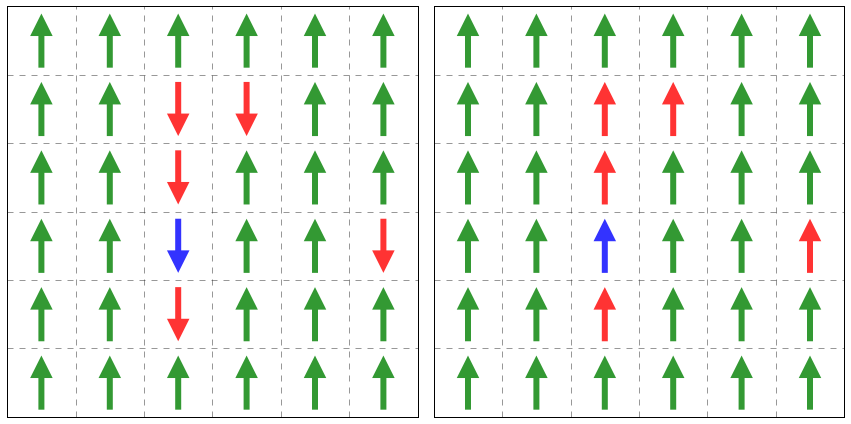

step 71: no coupling yet, 6 different spins
step 72: no coupling yet, 6 different spins
step 73: no coupling yet, 6 different spins
step 74: no coupling yet, 6 different spins
step 75: no coupling yet, 6 different spins
step 76: no coupling yet, 6 different spins
step 77: no coupling yet, 7 different spins
step 78: no coupling yet, 7 different spins
step 79: no coupling yet, 6 different spins
step 80: no coupling yet, 6 different spins


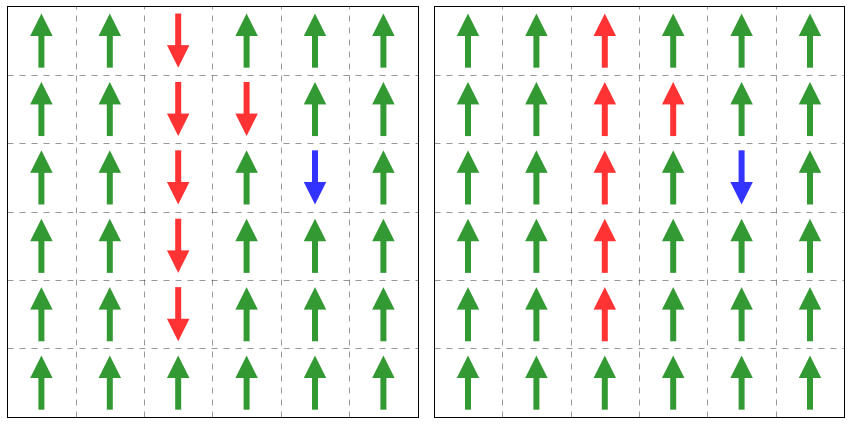

step 81: no coupling yet, 6 different spins
step 82: no coupling yet, 6 different spins
step 83: no coupling yet, 6 different spins
step 84: no coupling yet, 6 different spins
step 85: no coupling yet, 6 different spins
step 86: no coupling yet, 6 different spins
step 87: no coupling yet, 6 different spins
step 88: no coupling yet, 6 different spins
step 89: no coupling yet, 6 different spins
step 90: no coupling yet, 6 different spins


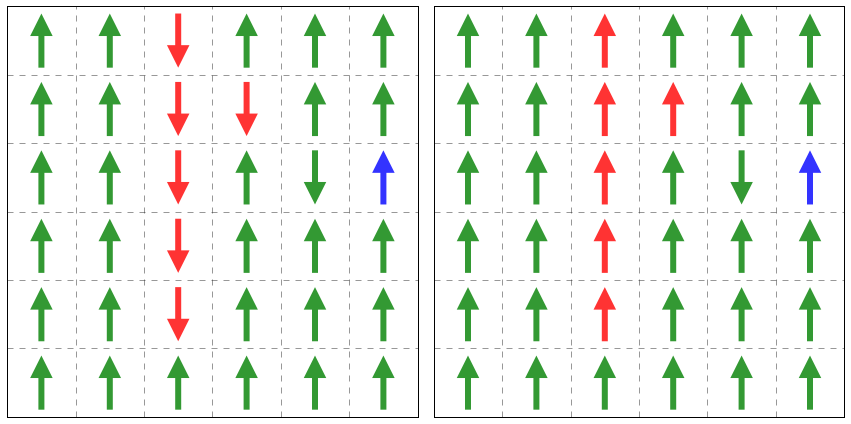

step 91: no coupling yet, 6 different spins
step 92: no coupling yet, 6 different spins
step 93: no coupling yet, 5 different spins
step 94: no coupling yet, 5 different spins
step 95: no coupling yet, 5 different spins
step 96: no coupling yet, 5 different spins
step 97: no coupling yet, 4 different spins
step 98: no coupling yet, 4 different spins
step 99: no coupling yet, 4 different spins
step 100: no coupling yet, 4 different spins


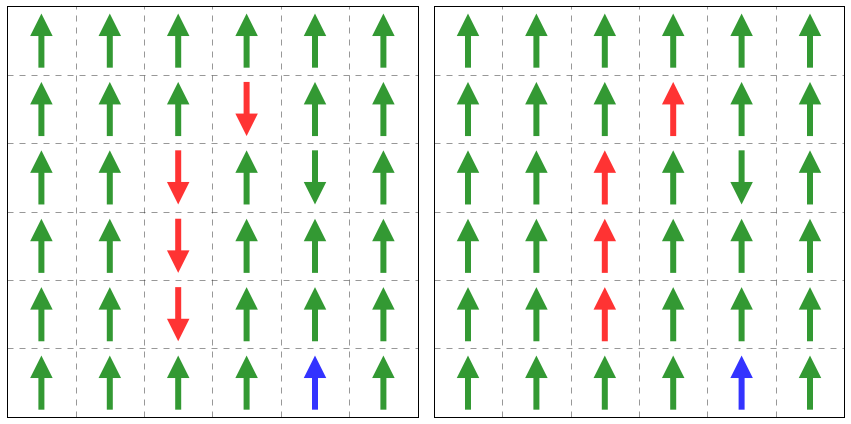

step 101: no coupling yet, 4 different spins
step 102: no coupling yet, 5 different spins
step 103: no coupling yet, 5 different spins
step 104: no coupling yet, 5 different spins
step 105: no coupling yet, 4 different spins
step 106: no coupling yet, 4 different spins
step 107: no coupling yet, 4 different spins
step 108: no coupling yet, 3 different spins
step 109: no coupling yet, 3 different spins
step 110: no coupling yet, 3 different spins


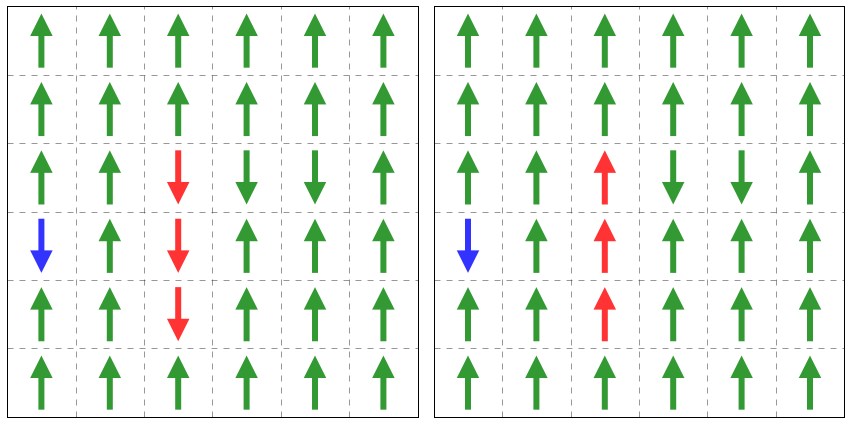

step 111: no coupling yet, 2 different spins
step 112: no coupling yet, 2 different spins
step 113: no coupling yet, 2 different spins
step 114: no coupling yet, 2 different spins
step 115: no coupling yet, 2 different spins
step 116: no coupling yet, 2 different spins
step 117: no coupling yet, 2 different spins
step 118: no coupling yet, 2 different spins
step 119: no coupling yet, 2 different spins
step 120: no coupling yet, 2 different spins


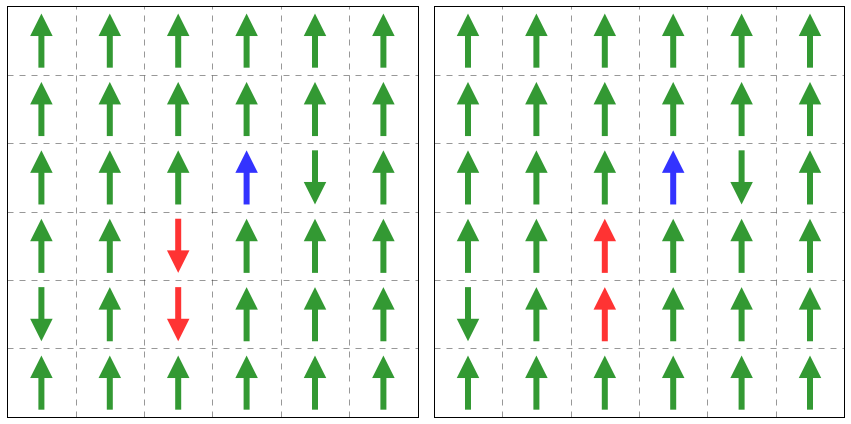

step 121: no coupling yet, 2 different spins
step 122: no coupling yet, 2 different spins
step 123: no coupling yet, 2 different spins
step 124: no coupling yet, 2 different spins
step 125: no coupling yet, 2 different spins
step 126: no coupling yet, 2 different spins
step 127: no coupling yet, 2 different spins
step 128: no coupling yet, 2 different spins
step 129: no coupling yet, 2 different spins
step 130: no coupling yet, 2 different spins


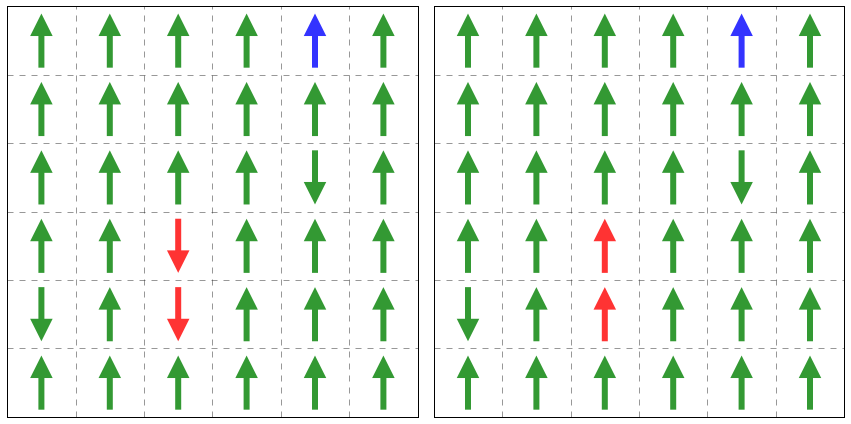

step 131: no coupling yet, 2 different spins
step 132: no coupling yet, 2 different spins
step 133: no coupling yet, 2 different spins
step 134: no coupling yet, 2 different spins
step 135: no coupling yet, 2 different spins
step 136: no coupling yet, 2 different spins
step 137: no coupling yet, 3 different spins
step 138: no coupling yet, 3 different spins
step 139: no coupling yet, 3 different spins
step 140: no coupling yet, 3 different spins


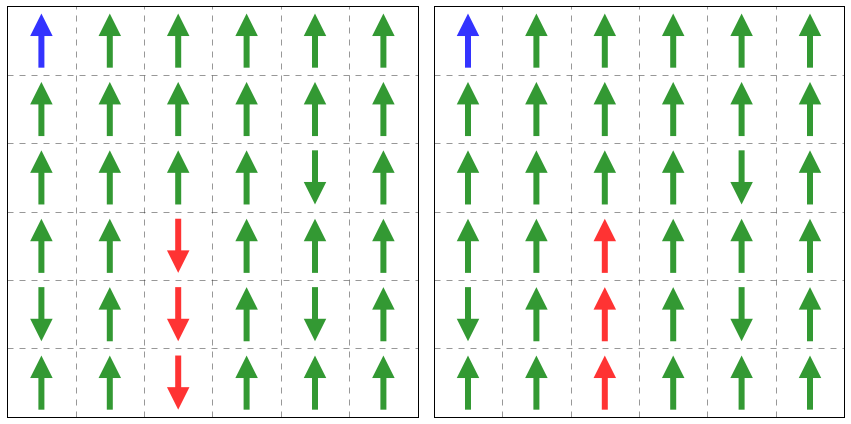

step 141: no coupling yet, 3 different spins
step 142: no coupling yet, 3 different spins
step 143: no coupling yet, 3 different spins
step 144: no coupling yet, 3 different spins
step 145: no coupling yet, 3 different spins
step 146: no coupling yet, 3 different spins
step 147: no coupling yet, 2 different spins
step 148: no coupling yet, 2 different spins
step 149: no coupling yet, 2 different spins
step 150: no coupling yet, 2 different spins


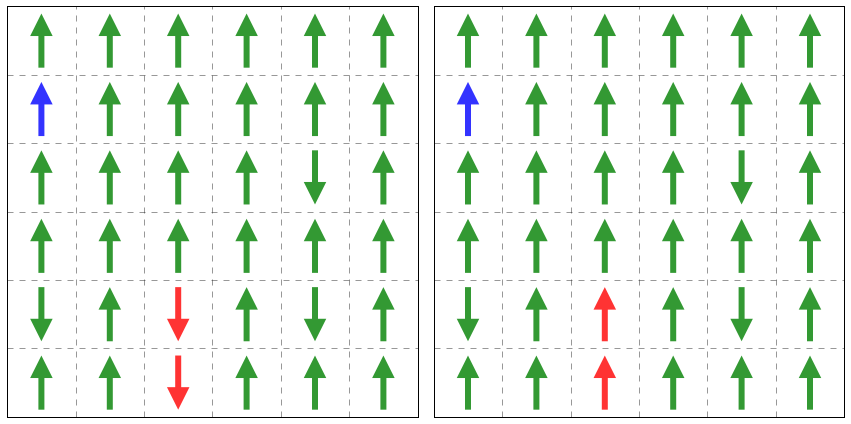

step 151: no coupling yet, 2 different spins
step 152: no coupling yet, 2 different spins
step 153: no coupling yet, 2 different spins
step 154: no coupling yet, 2 different spins
step 155: no coupling yet, 2 different spins
step 156: no coupling yet, 2 different spins
step 157: no coupling yet, 2 different spins
step 158: no coupling yet, 2 different spins
step 159: no coupling yet, 2 different spins
step 160: no coupling yet, 2 different spins


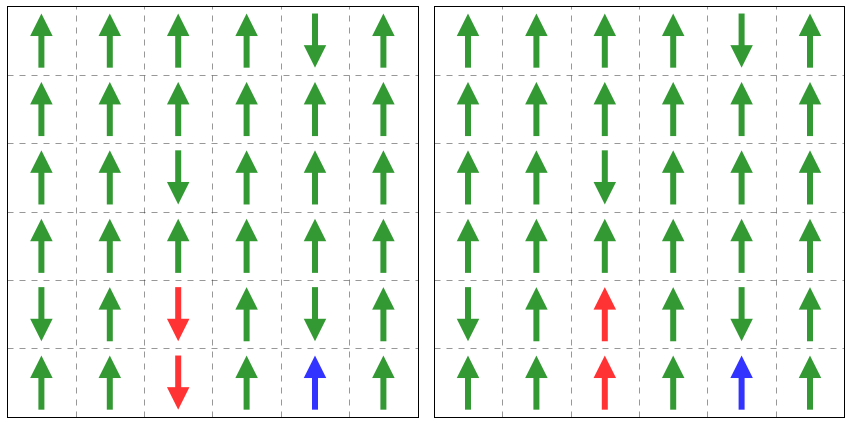

step 161: no coupling yet, 2 different spins
step 162: no coupling yet, 2 different spins
step 163: no coupling yet, 2 different spins
step 164: no coupling yet, 2 different spins
step 165: no coupling yet, 2 different spins
step 166: no coupling yet, 2 different spins
step 167: no coupling yet, 2 different spins
step 168: no coupling yet, 2 different spins
step 169: no coupling yet, 2 different spins
step 170: no coupling yet, 2 different spins


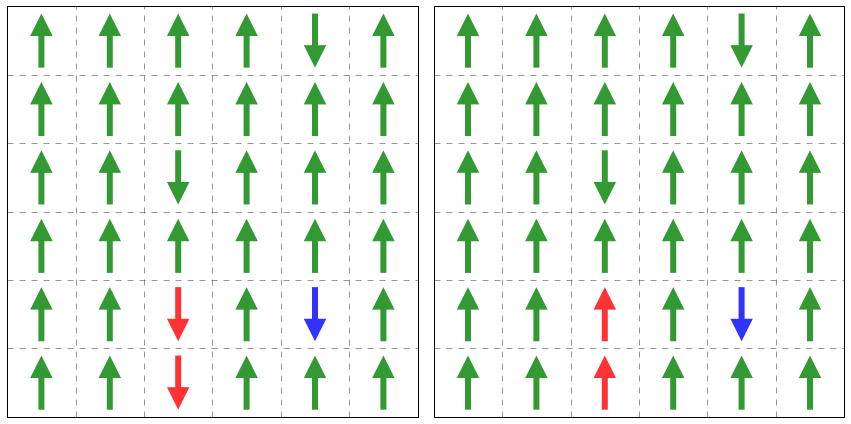

step 171: no coupling yet, 2 different spins
step 172: no coupling yet, 2 different spins
step 173: no coupling yet, 2 different spins
step 174: no coupling yet, 2 different spins
step 175: no coupling yet, 2 different spins
step 176: no coupling yet, 2 different spins
step 177: no coupling yet, 2 different spins
step 178: no coupling yet, 2 different spins
step 179: no coupling yet, 3 different spins
step 180: no coupling yet, 3 different spins


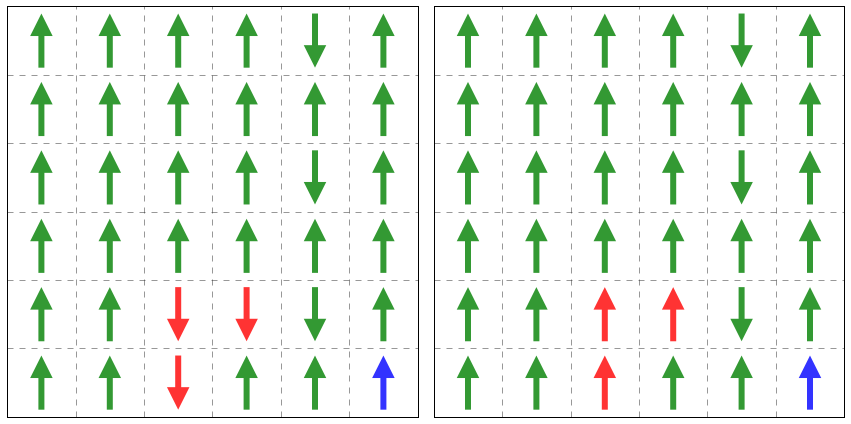

step 181: no coupling yet, 3 different spins
step 182: no coupling yet, 3 different spins
step 183: no coupling yet, 3 different spins
step 184: no coupling yet, 3 different spins
step 185: no coupling yet, 3 different spins
step 186: no coupling yet, 3 different spins
step 187: no coupling yet, 3 different spins
step 188: no coupling yet, 3 different spins
step 189: no coupling yet, 3 different spins
step 190: no coupling yet, 3 different spins


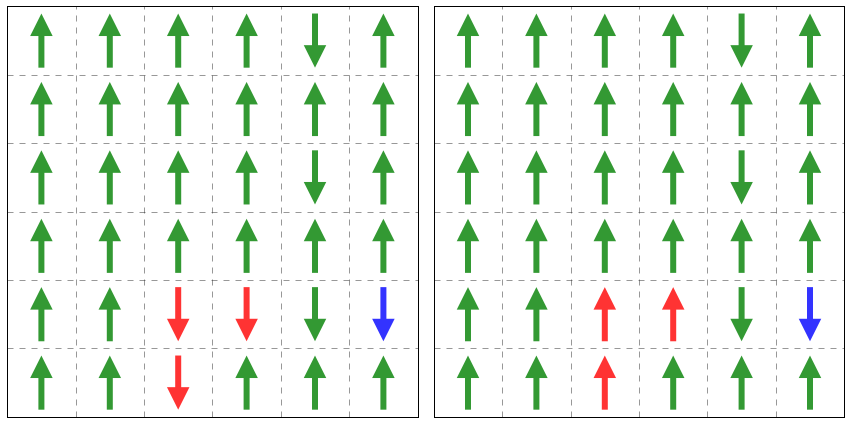

step 191: no coupling yet, 3 different spins
step 192: no coupling yet, 3 different spins
step 193: no coupling yet, 3 different spins
step 194: no coupling yet, 3 different spins
step 195: no coupling yet, 3 different spins
step 196: no coupling yet, 3 different spins
step 197: no coupling yet, 3 different spins
step 198: no coupling yet, 2 different spins
step 199: no coupling yet, 2 different spins
step 200: no coupling yet, 2 different spins


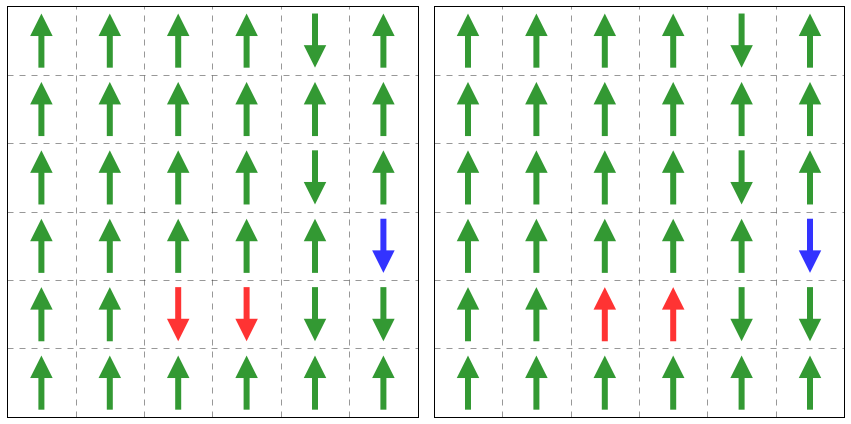

step 201: no coupling yet, 2 different spins
step 202: no coupling yet, 2 different spins
step 203: no coupling yet, 2 different spins
step 204: no coupling yet, 2 different spins
step 205: no coupling yet, 2 different spins
step 206: no coupling yet, 2 different spins
step 207: no coupling yet, 2 different spins
step 208: no coupling yet, 2 different spins
step 209: no coupling yet, 2 different spins
step 210: no coupling yet, 2 different spins


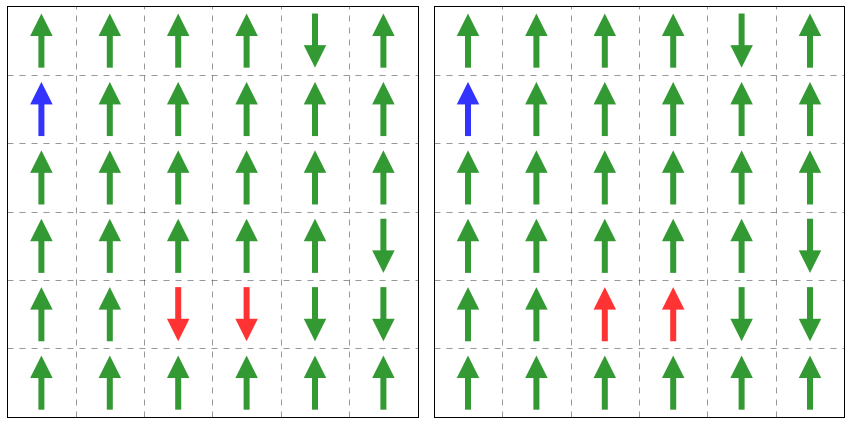

step 211: no coupling yet, 2 different spins
step 212: no coupling yet, 2 different spins
step 213: no coupling yet, 2 different spins
step 214: no coupling yet, 2 different spins
step 215: no coupling yet, 2 different spins
step 216: no coupling yet, 2 different spins
step 217: no coupling yet, 2 different spins
step 218: no coupling yet, 2 different spins
step 219: no coupling yet, 2 different spins
step 220: no coupling yet, 2 different spins


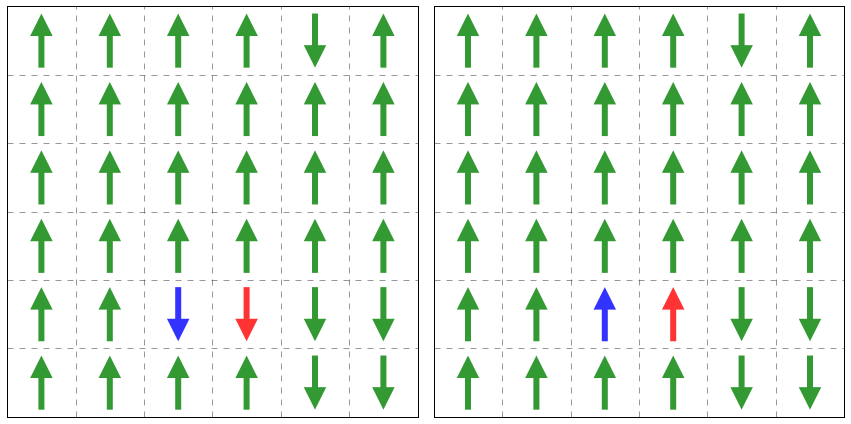

step 221: no coupling yet, 2 different spins
step 222: no coupling yet, 2 different spins
step 223: no coupling yet, 2 different spins
step 224: no coupling yet, 2 different spins
step 225: no coupling yet, 2 different spins
step 226: no coupling yet, 2 different spins
step 227: no coupling yet, 2 different spins
step 228: no coupling yet, 2 different spins
step 229: no coupling yet, 2 different spins
step 230: no coupling yet, 2 different spins


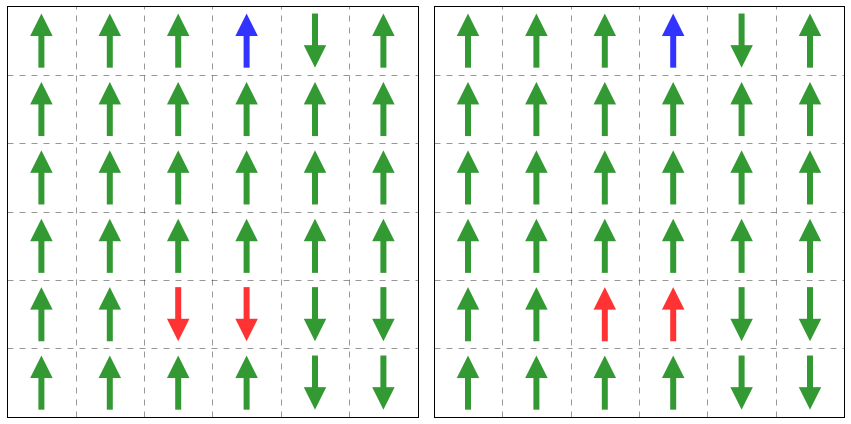

step 231: no coupling yet, 2 different spins
step 232: no coupling yet, 2 different spins
step 233: no coupling yet, 2 different spins
step 234: no coupling yet, 2 different spins
step 235: no coupling yet, 2 different spins
step 236: no coupling yet, 2 different spins
step 237: no coupling yet, 2 different spins
step 238: no coupling yet, 2 different spins
step 239: no coupling yet, 2 different spins
step 240: no coupling yet, 2 different spins


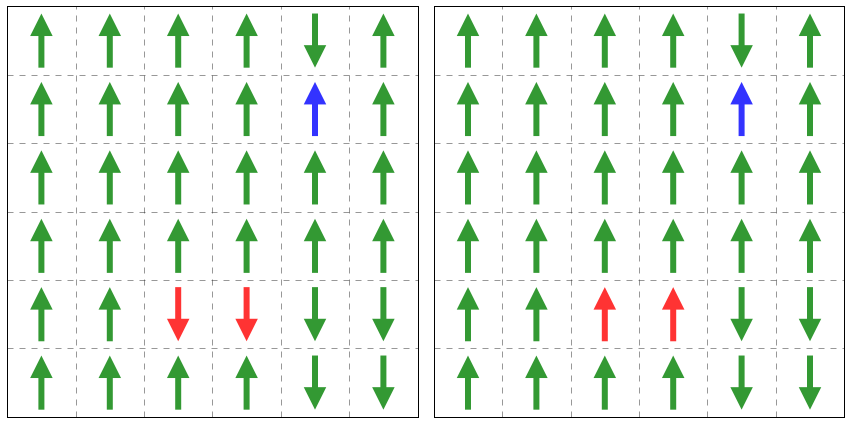

step 241: no coupling yet, 2 different spins
step 242: no coupling yet, 2 different spins
step 243: no coupling yet, 2 different spins
step 244: no coupling yet, 3 different spins
step 245: no coupling yet, 3 different spins
step 246: no coupling yet, 3 different spins
step 247: no coupling yet, 3 different spins
step 248: no coupling yet, 3 different spins
step 249: no coupling yet, 3 different spins
step 250: no coupling yet, 3 different spins


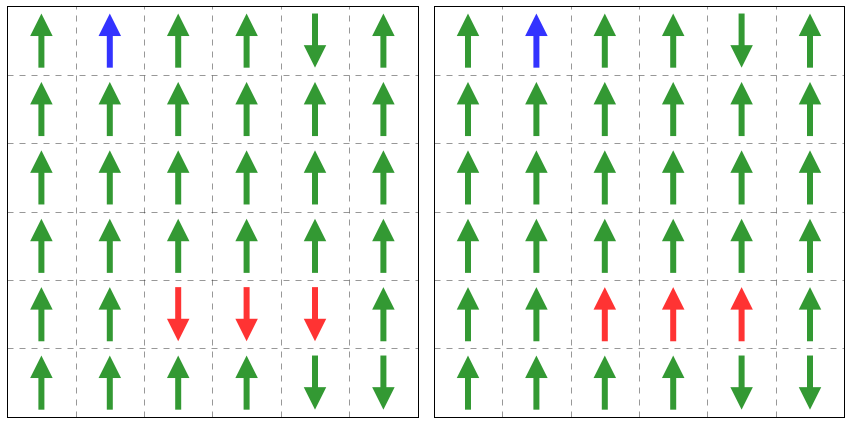

step 251: no coupling yet, 2 different spins
step 252: no coupling yet, 2 different spins
step 253: no coupling yet, 2 different spins
step 254: no coupling yet, 2 different spins
step 255: no coupling yet, 2 different spins
step 256: no coupling yet, 2 different spins
step 257: no coupling yet, 1 different spins
step 258: no coupling yet, 1 different spins
step 259: no coupling yet, 1 different spins
step 260: coupling


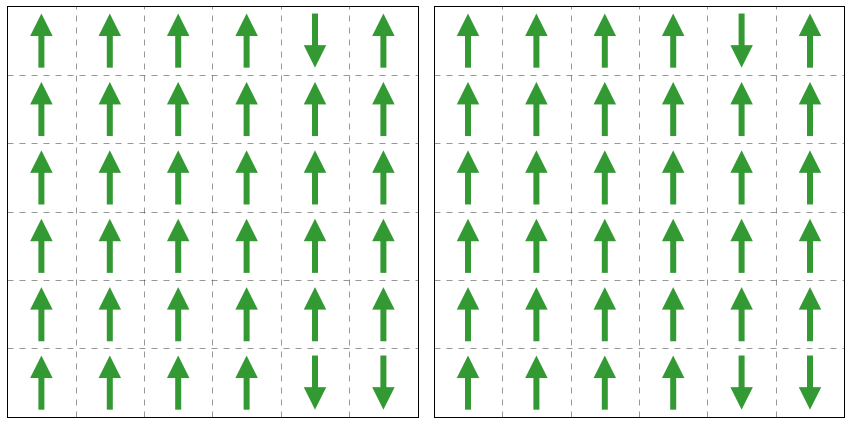

In [15]:
output_dir = 'snapshots'
if not os.path.exists(output_dir): 
    os.makedirs(output_dir)
    
def plot_many_configurations(conf, filename, L, colors={}):
    pylab.figure(figsize=(6 * len(conf), 6))
    s = 1.0 / L
    for i_c in range(len(conf)):
        c = conf[i_c]
        pylab.subplot(1, len(conf), i_c + 1)
        for l in range(L ** 2):
            x, y = ((l // L) + 0.5) * s, ((l - (l // L) * L) + 0.5) * s
            dy = c[l] * 0.85 / float(L)
            arrow = FancyArrowPatch((x, y - 0.5 * dy), (x, y + 0.5 * dy), \
                    fc=colors[l], color='.2', lw=0, alpha=.8, \
                    arrowstyle="Simple, head_length=" + str(0.9 * 150 * s) \
                    + ", head_width=" + str(0.9 * 150 * s) + ", tail_width=" \
                    + str(0.9 * 40 * s))
            pylab.gca().add_patch(arrow)
        pylab.axis('scaled')
        pylab.axis([0, 1, 0, 1])
        pylab.gca().set_xticks([])
        pylab.gca().set_yticks([])
        [pylab.axhline(y=(i * s), ls='--', c='.2', lw=0.5) for i in range(L)]
        [pylab.axvline(x=(j * s), ls='--', c='.2', lw=0.5) for j in range(L)]
    pylab.tight_layout()
    pylab.savefig(output_dir + '/' + filename)
    pylab.show()
    pylab.clf()

L = 6
N = L * L
nbr = {i : ((i // L) * L + (i + 1) % L, (i + L) % N,
            (i // L) * L + (i - 1) % L, (i - L) % N) \
                                    for i in range(N)}

filename = 'data_L%i.txt' % L
if os.path.isfile(filename):
    f = open(filename, 'r')
    S1 = [int(i) for i in f.read().split()]
    f.close()
    if len(S1) != N: exit('wrong input')
    print 'initial config read from', filename
else:
    S1 = [random.choice([-1, 1]) for i in range(N)]
    print 'random initial config'
    
S2 = [1] * N
nsteps = 10000
nskip  = 10     # plot a snapshot every nskip steps
beta = 0.4
random.seed('abcde')

for step in range(nsteps):
    k = random.randint(0, N - 1)
    Upsilon = random.uniform(0.0, 1.0)
    h1 = sum(S1[nn] for nn in nbr[k])
    S1[k] = -1
    if Upsilon < 1.0 / (1.0 + math.exp(-2.0 * beta * h1)): 
        S1[k] = 1
    h2 = sum(S2[nn] for nn in nbr[k])
    S2[k] = -1
    if Upsilon < 1.0 / (1.0 + math.exp(-2.0 * beta * h2)):
        S2[k] = 1
    if S1 == S2:
        print 'step %i: coupling' % step
        plot_many_configurations([S1, S2], 'snap_%06i.png' % step, L, {j : 'g' for j in range(N)})
        break
    else:
        print 'step %i: no coupling yet, %i different spins' % (step, sum(S1[ii] != S2[ii] for ii in range(N)))
    # begin graphic output
    # colormap: green for equal spins, red for different spins, blue for site k
    if step % nskip == 0:
        colors = {j : (S1[j] == S2[j]) * 'g' + (S1[j] != S2[j]) * 'r' for j in range(N)}
        colors[k] = 'b'
        plot_many_configurations([S1, S2], 'snap_%06i.png' % step, L, colors)


## Cluster Ising

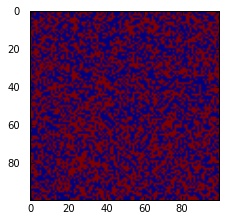

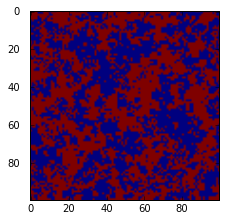

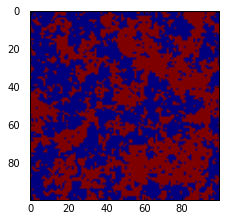

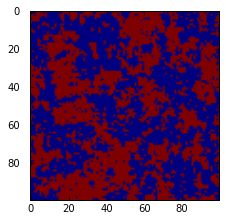

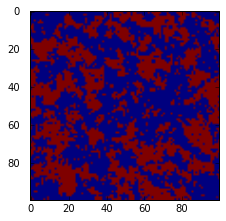

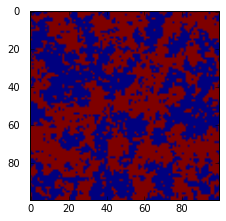

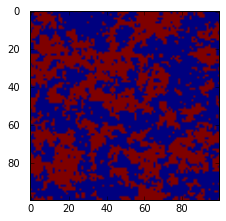

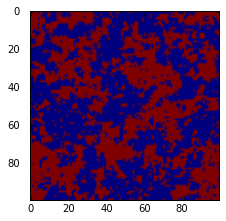

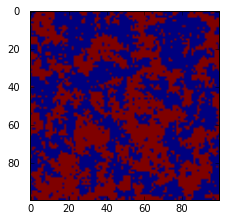

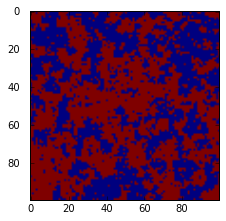

In [16]:
L = 100
N = L * L
nbr = {i : ((i // L) * L + (i + 1) % L, (i + L) % N,
            (i // L) * L + (i - 1) % L, (i - L) % N)
                                    for i in range(N)}
T = 2.5
p  = 1.0 - math.exp(-2.0 / T)
nsteps = 10000
delta_plot = 1000
S = [random.choice([1, -1]) for k in range(N)]
for step in range(nsteps):
    k = random.randint(0, N - 1)
    Pocket, Cluster = [k], [k]
    while Pocket != []:
        j = random.choice(Pocket)
        for l in nbr[j]:
            if S[l] == S[j] and l not in Cluster \
                   and random.uniform(0.0, 1.0) < p:
                Pocket.append(l)
                Cluster.append(l)
        Pocket.remove(j)
    for j in Cluster:
        S[j] *= -1
    if ((step % delta_plot) == 0):
        fig, ax = plt.subplots(figsize = (fig_width, fig_width), dpi=400, frameon=True)
        to_plot = np.resize(np.array(S), (L,L))
        plt.imshow(to_plot)
        ax.set_aspect('equal')

In [17]:
colors = []
for i in xrange(len(S)):
    if S[i] > 0:
        colors.append('k')
    else:
        colors.append('r')